In [1]:
cd MF

/home/shse/Documents/sim_mf_bonne/MF


In [2]:
import numpy as np
import sys
#sys.path.append('mean_field_adapt')
#from transfer_functions.tf_simulation import single_experiment_2,single_experiment
from transfer_functions.load_config import load_transfer_functions,load_transfer_functions_with_ALL_params
from scipy.integrate import odeint
from single_cell_models.cell_library import get_neuron_params
from synapses_and_connectivity.syn_and_connec_library import get_connectivity_and_synapses_matrix
from transfer_functions.tf_simulation import reformat_syn_parameters
import matplotlib.pylab as plt
from transfer_functions.data import *
from graphs import *


from scipy.optimize import fsolve
from scipy.optimize import minimize
import math

In [3]:
from MF_functions_clean import *

## First, build the MF architecture and set the right parameters


In [4]:
h=0.0001
T=0.005
Ntot=10000

number_of_populations=2 # variate this paramater, first are excitators and second inihibitors 
number_of_adaptive=1

p_con=np.ones((2,2))*(0.05) #np.ones((4,4))*(0.05) ou number_of_pop*0.05
#p_con[2][2]=0.6 #inh tres connecté 
#p_con[1][2]=p_con[2][1]=0 ## the two FS populations are not connected !
p_pois=np.ones(2)*0.05

''' Now params becomes a dictionary'''

#numb_par=28
params={}

params['diff']=[0,0] # by default nothing changes from neuron model
params['tstep']=5e-4 
params['numb_var']=number_of_populations**2+number_of_populations+number_of_adaptive#14 # total numb of var
# remove number_of_populations**2 for first order 
params['tauw']=[1,1e-3] # tau_w 1.5
params['a']=[0,0] # a 0,0
params['b']=[1e-12,0] # b 
params['El']=[-70e-3,-65e-3] # El -70e-3,-65e-3
params['total_size']=10000
params['size_subpop']=[8000,2000] 
params['numb_pop']=number_of_populations
params['numb_adapt']=number_of_adaptive
params['tau_e']=5e-3 # Tau_e
params['tau_i']=5e-3 # Tau_i
params['qe']=1.5e-9 # Qe 1.5e-9
params['qi']=5e-9 # Qi
params['Ee']=0 # Ee
params['Ei']=-80e-3 # Ei
params['Gl']=[10e-9,10e-9]
params['Vthre']=[-50e-3,-50e-3]
params['Cm']=[200e-12,200e-12]



params['h']=h
params['T']=T
params['mu']=mu_V_dN_dp #_FO (for firdt order)

params['ext_inp']=[2.5,2.5] #external input : Poisson law, change params 2.5 HZ
params['inp_funct']=0 # input function
params['inp_par']=0 # input parameters
params['numb_sub_exc']=1# numb_sub_exc
params['numb_sub_inh']=1# numb_sub_inh
params['p_conn']=p_con # not anymore dp, here it is plain p 
params['p_pois']=p_pois




print(params)

{'diff': [0, 0], 'tstep': 0.0005, 'numb_var': 7, 'tauw': [1, 0.001], 'a': [0, 0], 'b': [1e-12, 0], 'El': [-0.07, -0.065], 'total_size': 10000, 'size_subpop': [8000, 2000], 'numb_pop': 2, 'numb_adapt': 1, 'tau_e': 0.005, 'tau_i': 0.005, 'qe': 1.5e-09, 'qi': 5e-09, 'Ee': 0, 'Ei': -0.08, 'Gl': [1e-08, 1e-08], 'Vthre': [-0.05, -0.05], 'Cm': [2e-10, 2e-10], 'h': 0.0001, 'T': 0.005, 'mu': <function mu_V_dN_dp at 0x7f02238ec430>, 'ext_inp': [2.5, 2.5], 'inp_funct': 0, 'inp_par': 0, 'numb_sub_exc': 1, 'numb_sub_inh': 1, 'p_conn': array([[0.05, 0.05],
       [0.05, 0.05]]), 'p_pois': array([0.05, 0.05])}


In [5]:
# Run the MF without adaptation a = b = 0 
#sys.path.append('../')

NTWK='CONFIG1'


NRN1='RS-cell'
NRN2='FS-cell'


TF_temp = load_transfer_functions_with_ALL_params(NRN1, NRN2, NTWK,params)
#TF_temp2 = load_transfer_functions(NRN3, NRN3, NTWK) # lazy to rewrite a load_TF function

TF=(TF_temp[0],TF_temp[1]) # TF defined as a tuple

params['TF']=TF


### Integration of the MF equations

##### Straight to second order !

In [6]:
#np.random.seed(10)
#x0=np.random.rand(7)*1e-5

x0=np.ones(7)*1e-5 
x0[0]=0.6 #ve exp 
x0[1]=7.0 #vi exp
x0[6]=x0[0]*1e-12 #w exp 60e-12
print(x0)
time=0
t_trace=[]
x_trace_RS=[]
TF_trace_RS=[]



print(x0)
time=0
    
for i in np.arange(0,5,params['tstep']):
    TF_inst=rk4_dN_dp_General(x0,params,time,MeanField_dN_dp) #MeanField_dN_dp est la fonction
    if (i%0.5==0):print('i = ', i, '\n')
    time+=params['tstep']
    t_trace.append(time)
    x_trace_RS.append(x0.copy())
    TF_trace_RS.append(TF_inst.copy())
    

[6.e-01 7.e+00 1.e-05 1.e-05 1.e-05 1.e-05 6.e-13]
[6.e-01 7.e+00 1.e-05 1.e-05 1.e-05 1.e-05 6.e-13]
i =  0.0 

i =  0.5 

i =  1.0 

i =  1.5 

i =  2.0 

i =  2.5 

i =  3.0 

i =  3.5 

i =  4.0 

i =  4.5 



In [7]:
final_state=x_trace_RS[-1] 
print(final_state)
#intégrer la dérivé , ici valeurs de nu_out 
#trouver pts fixes des, donné les freq vers les quelles elles 

[3.55974463e+00 1.36879000e+01 6.81682739e-01 1.32181306e+00
 1.32181306e+00 2.91536730e+00 3.54463365e-12]


In [8]:
x_transp=np.transpose(x_trace_RS)
#TF_transp=np.transpose(TF_trace_RS)
ve1=x_transp[0]#[1000:] # remove first 10000 elements
#ve2=x_transp[1]#[1000:]
vi1=x_transp[1]#[1000:]
#vi2=x_transp[3]#[1000:]
#ce1i1=np.sqrt(x_transp[5])#[1000:]
#cii=np.sqrt(x_transp[5])#[1000:]
#w1=x_transp[20]
#w2=x_transp[21]

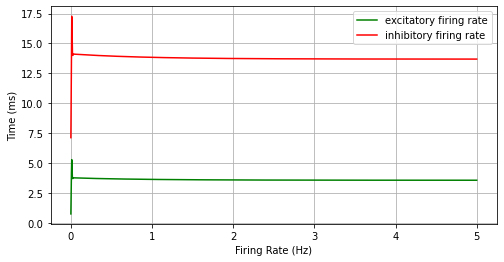

In [9]:
plt.figure(figsize=(8, 4))
plt.plot(t_trace, ve1, color="green", label="excitatory firing rate")
plt.plot(t_trace, vi1, color="red", label="inhibitory firing rate")




plt.xlabel("Firing Rate (Hz)")
plt.grid(True)
plt.ylabel("Time (ms)")
plt.legend()
#plt.title("Mean-Field Dynamics")
#plt.ylim(-20,20)
#plt.xlim(0,0.1)
plt.show()

### Load network activity to compare with MF

WARNING    "i" is an internal variable of group "synapses", but also exists in the run namespace with the value 4.9995. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    "i" is an internal variable of group "synapses_1", but also exists in the run namespace with the value 4.9995. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    "i" is an internal variable of group "synapses_2", but also exists in the run namespace with the value 4.9995. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    "i" is an internal variable of group "synapses_3", but also exists in the run namespace with the value 4.9995. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


--##Start simulation##--
--##End simulation##--
(1999,)
0.15191269751133188
0.2884051337710038


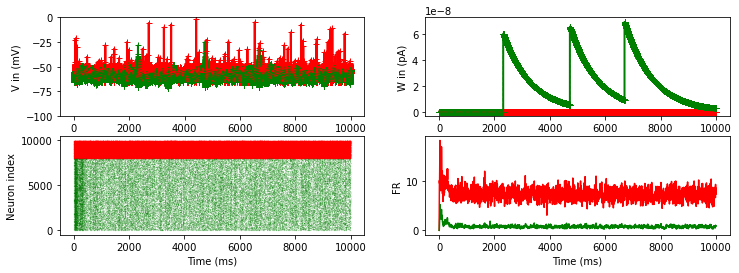

In [8]:
# import libraries
import matplotlib.pyplot as plt
import numpy as np
from brian2 import *


#########################################################
#Define conditions for simulation
#start Brian scope:
start_scope()
#set dt value for integration (ms):
DT=0.1
seed(1)
defaultclock.dt = DT*ms

#total duration of the simulation (ms):
TotTime=10000
duration = TotTime*ms


#######################################################
#set the number of neuron of each population:
#inhibitory Fast Spiking (FS, population 1):
N1 = 2000
#Excitatory Regular Spiking (RS, population 2):
N2 = 8000


########################################################
# define equations of the model 
# define units of parameter
eqs='''
dv/dt = (-GsynE*(v-Ee)-GsynI*(v-Ei)-gl*(v-El)+ gl*Dt*exp((v-Vt)/Dt)-w + Is)/Cm : volt (unless refractory)
dw/dt = (a*(v-El)-w)/tau_w:ampere
dGsynI/dt = -GsynI/Tsyn : siemens
dGsynE/dt = -GsynE/Tsyn : siemens
Pvar:1
Is:ampere
Cm:farad
gl:siemens
El:volt
a:siemens
tau_w:second
Dt:volt
Vt:volt
Ee:volt
Ei:volt
Tsyn:second
'''

########################################################
#Create populations:

	# Population 1 - FS

b1 = 0.0*pA #no adaptation for FS
#generate the population
G1 = NeuronGroup(N1, eqs, threshold='v > 0.0*mV', reset='v = -65*mV', refractory='5*ms', method='heun')
#set values:
# initial values of variables:
G1.v = -65 *mV
G1.w = 0.0 *pA
G1.GsynI =0.0 *nS
G1.GsynE =0.0 *nS
# parameters values:
#soma:
G1.Cm = 200.*pF
G1.gl = 10.*nS
G1.El = -65.*mV
G1.Vt = -50.*mV
G1.Dt = 0.5*mV
G1.tau_w = 1.0 *ms #(no adapation, just to do not have error due to zero division)
G1.a = 0.0 *nS
G1.Is = 0.0  
#synapses:
G1.Ee =0.*mV
G1.Ei =-80.*mV
G1.Tsyn =5.*ms


# Population 2 - RS
b2 = 60.*pA
#generate the population
G2 = NeuronGroup(N2, eqs, threshold='v > 0.0*mV', reset='v = -70*mV; w += b2', refractory='5*ms',  method='heun')
#set values:
# initial values of variables:
G2.v = -65.*mV
G2.w = 0. *pA
G2.GsynI =0.0 *nS
G2.GsynE =0.0 *nS
# parameters values:
#soma:
G2.Cm = 200.*pF
G2.gl = 10.*nS
G2.El = -70.*mV
G2.Vt = -50.*mV
G2.Dt = 2.*mV
G2.tau_w = 1000.*ms
G2.a = 0.*nS
G2.Is = 0.*nA  
#synpases:
G2.Ee =0.*mV
G2.Ei =-80.*mV
G2.Tsyn =5.*ms




#######################################################
# external drive---------------------------------------

P_ed=PoissonGroup(8000, rates= 2.5*Hz) 


#######################################################
# connections-------------------------------------------
#quantal increment when spike:
Qi=5.*nS
Qe=1.5*nS

#probability of connection
prbC= 0.05 

#synapses from FS to RS:
S_12 = Synapses(G1, G2, on_pre='GsynI_post+=Qi') #'v_post -= 1.*mV')
S_12.connect('i!=j', p=prbC)
#synapses from FS to FS:
S_11 = Synapses(G1, G1, on_pre='GsynI_post+=Qi')
S_11.connect('i!=j',p=prbC)
#synapses from RS to FS:
S_21 = Synapses(G2, G1, on_pre='GsynE_post+=Qe')
S_21.connect('i!=j',p=prbC)
#synapses from RS to RS:
S_22 = Synapses(G2, G2, on_pre='GsynE_post+=Qe')
S_22.connect('i!=j', p=prbC)



#synapses from external drive to both populations:
S_ed_in = Synapses(P_ed, G1, on_pre='GsynE_post+=Qe')
S_ed_in.connect(p=prbC)

S_ed_ex = Synapses(P_ed, G2, on_pre='GsynE_post+=Qe')
S_ed_ex.connect(p=prbC)


######################################################
#set recording during simulation
#number of neuron record of each population:
Nrecord=1

M1G1 = SpikeMonitor(G1)
M2G1 = StateMonitor(G1, 'v', record=range(Nrecord))
M3G1 = StateMonitor(G1, 'w', record=range(Nrecord))
FRG1 = PopulationRateMonitor(G1)


M1G2 = SpikeMonitor(G2)
M2G2 = StateMonitor(G2, 'v', record=range(Nrecord))
M3G2 = StateMonitor(G2, 'w', record=range(Nrecord))
FRG2 = PopulationRateMonitor(G2)


#######################################################

#Run the simulation

print('--##Start simulation##--')
run(duration)
print('--##End simulation##--')


#######################################################
#Prepare recorded data

#organize arrays for raster plots:
RasG1 = np.array([M1G1.t/ms, [i+N2 for i in M1G1.i]])
RasG2 = np.array([M1G2.t/ms, M1G2.i])


#organize time series of single neuron variables
LVG1=[]
LwG1=[]
LVG2=[]
LwG2=[]
for a in range(Nrecord):
    LVG1.append(array(M2G1[a].v/mV))
    LwG1.append(array(M3G1[a].w/mamp))
    LVG2.append(array(M2G2[a].v/mV))
    LwG2.append(array(M3G2[a].w/mamp))

Ltime=array(M2G1.t/ms)

#Calculate population friing rate :

#function for binning:
def bin_array(array, BIN, time_array):
    N0 = int(BIN/(time_array[1]-time_array[0]))
    N1 = int((time_array[-1]-time_array[0])/BIN)
    return array[:N0*N1].reshape((N1,N0)).mean(axis=1)


BIN=5
time_array = np.arange(int(TotTime/DT))*DT

LfrG2=np.array(FRG2.rate/Hz)
TimBinned,popRateG2=bin_array(time_array, BIN, time_array),bin_array(LfrG2, BIN, time_array)

LfrG1=np.array(FRG1.rate/Hz)
TimBinned,popRateG1=bin_array(time_array, BIN, time_array),bin_array(LfrG1, BIN, time_array)

Lt1G1=array(M2G1.t/ms)
Lt2G1=array(M3G1.t/ms)
Lt1G2=array(M2G2.t/ms)
Lt2G2=array(M3G2.t/ms)

mean_LVG1 = np.mean(LVG1,axis=0)
max_LVG1 = np.max(LVG1,axis=0)
min_LVG1 = np.min(LVG1,axis=0)
mean_LwG1 = np.mean(LwG1,axis=0)
max_LwG1 = np.max(LwG1,axis=0)
min_LwG1 = np.min(LwG1,axis=0)
mean_LVG2 = np.mean(LVG2,axis=0)
max_LVG2 = np.max(LVG2,axis=0)
min_LVG2 = np.min(LVG2,axis=0)
mean_LwG2 = np.mean(LwG2,axis=0)
max_LwG2 = np.max(LwG2,axis=0)
min_LwG2 = np.min(LwG2,axis=0)

fig=plt.figure(figsize=(12,4))
ax1=fig.add_subplot(221)
ax2=fig.add_subplot(222)

for a in range(Nrecord):
    ax1.plot(Lt1G1, LVG1[a],'r:',linewidth=0.5)
    ax1.plot(Lt1G2, LVG2[a],'g:',linewidth=0.5)

for a in range(Nrecord):
    ax2.plot(Lt2G1, LwG1[a],'r:',linewidth=0.5)
    ax2.plot(Lt2G2, LwG2[a],'g:',linewidth=0.5)

ax1.plot(Lt1G1, mean_LVG1,'r',linewidth=2.0)
ax2.plot(Lt2G1, mean_LwG1,'r',linewidth=2.0)
ax1.plot(Lt1G2, mean_LVG2,'g',linewidth=2.0)
ax2.plot(Lt2G2, mean_LwG2,'g',linewidth=2.0)
ax1.plot(Lt1G1, max_LVG1,'r+',linewidth=0.5)
ax2.plot(Lt2G1, max_LwG1,'r+',linewidth=1.0)
ax1.plot(Lt1G2, max_LVG2,'g+',linewidth=0.5)
ax2.plot(Lt2G2, max_LwG2,'g+',linewidth=1.0)
ax1.plot(Lt1G1, min_LVG1,'r--',linewidth=0.5)
ax2.plot(Lt2G1, min_LwG1,'r--',linewidth=1.0)
ax1.plot(Lt1G2, min_LVG2,'g--',linewidth=0.5)
ax2.plot(Lt2G2, min_LwG2,'g--',linewidth=1.0)


ax1.set_ylim([-100, 0])
ax1.set_xlabel('Time (ms)')
ax1.set_ylabel('V in (mV)')
ax2.set_xlabel('Time (ms)')
ax2.set_ylabel('W in (pA)')

ax3=fig.add_subplot(223)
ax3.plot(RasG1[0], RasG1[1], '.r',markersize=0.1)
ax3.plot(RasG2[0], RasG2[1], '.g',markersize=0.1)
ax3.set_xlabel('Time (ms)')
ax3.set_ylabel('Neuron index')

ax4=fig.add_subplot(224)
ax4.plot(TimBinned,popRateG1, 'r')
ax4.plot(TimBinned,popRateG2, 'g',markersize=0.1)
ax4.set_xlabel('Time (ms)')
ax4.set_ylabel('FR')

print(popRateG1.shape)
print(numpy.std(popRateG1[1000:])/np.mean(popRateG1[1000:]))
print(numpy.std(popRateG2[1000:])/np.mean(popRateG2[1000:]))
plt.show()
	

In [74]:
arr=[popRateG1,popRateG2,LwG2,LVG1,LVG2,LfrG1,LfrG2,TimBinned,time_array]
np.save('2pop_data.npy', arr)
print("Your array has been saved to 2pop_data.npy")

WARNING    /home/shse/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
 [py.warnings]


Your array has been saved to 2pop_data.npy


In [76]:
data = np.load('2pop_data.npy',allow_pickle=True)
print("The data is:")
print(data)

The data is:
[array([0. , 5.2, 8.2, ..., 7.5, 5.7, 6.7])
 array([0.   , 0.025, 0.225, ..., 0.1  , 0.025, 0.025])
 list([array([0.00000000e+00, 2.66666667e-12, 5.31982370e-12, ...,
       4.90407489e-08, 4.90411934e-08, 4.90416527e-08])])
 list([array([-65.        , -65.        , -65.        , ..., -55.85157939,
       -55.70299375, -55.56038117])])
 list([array([-65.        , -65.04999447, -65.09974044, ..., -61.07262722,
       -61.01745606, -60.96622138])])
 array([0., 0., 0., ..., 0., 5., 0.]) array([0., 0., 0., ..., 0., 0., 0.])
 array([2.45000e+00, 7.45000e+00, 1.24500e+01, ..., 9.98245e+03,
       9.98745e+03, 9.99245e+03])
 array([0.0000e+00, 1.0000e-01, 2.0000e-01, ..., 9.9997e+03, 9.9998e+03,
       9.9999e+03])]


In [77]:
popRateG1=data[0]
popRateG2=data[1]
LwG2=data[2]
LVG1=data[3]
LVG2=data[4]
LfrG1=data[5]
LfrG2=data[6]

In [11]:
net_spikes = M1G2.it
i, t = net_spikes
i = i * 1; t = t * 1
net_spikes = [i, t]
print("E spikes: {} I spikes: {}".format(M1G2.num_spikes, M1G1.num_spikes))

E spikes: 63330 I spikes: 149571


In [18]:
print(duration)

10. s


In [39]:
def getSpikeIntervals(spikes):
    spikeTrain = spikes.spike_trains()[0]
    spikeIntervals = np.zeros(shape=len(spikeTrain)-1)
    for i in range(len(spikeTrain)-1):
        spikeIntervals[i] = (spikeTrain[i+1]-spikeTrain[i])/ms
    return spikeIntervals

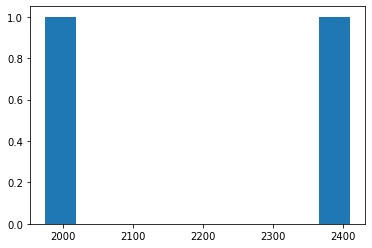

In [40]:
plt.hist(getSpikeIntervals(M1G2)); plt.show()

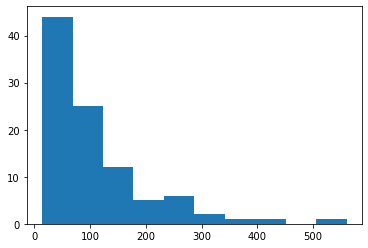

In [41]:
plt.hist(getSpikeIntervals(M1G1)); plt.show()

In [43]:
import time

No handles with labels found to put in legend.


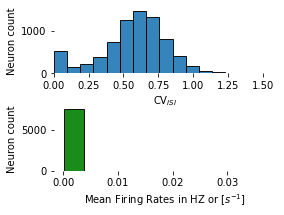

In [107]:
fig, axs = plt.subplots(2, 1, figsize=(4, 3))
sp = M1G2.i #commencer avec un 1er spike #par neuron
times = M1G2.t/ms
#duration=10000.*ms
nNeurons = max(sp) + 1
nSpikes = len(sp)

spiketimes = {}
for n in np.arange(nNeurons):
    ts = list(times[(np.where(sp == n))])
    #ts = [duration for duration in ts if duration > 500 * ms]
    spiketimes[n] = ts
isi_stds = []
isi_cvs = []
for n in range(nNeurons):
    isi_std = np.std(np.diff(spiketimes[n]))
    isi_cv = np.std(np.diff(spiketimes[n])) / np.mean(np.diff(spiketimes[n]))
    #axs[0].scatter(n, np.std(np.diff(spiketimes[n])))
    isi_stds.append(isi_std)  
    isi_cvs.append(isi_cv)
        
meanFiringRates = []
for n in range(nNeurons):
    meanFiringRates.append(1/np.mean(np.diff(spiketimes[n])))
        
    

axs[0].hist(isi_cvs, bins=15, alpha=0.9, edgecolor='black');
axs[1].hist(meanFiringRates, bins=10, alpha=0.9, edgecolor='black',color="green");
#for n in range(nNeurons):
    #axs[2].scatter(n, isi_std);

    
for k in range(1):
    leg = axs[k].legend(loc=1)
    leg.get_frame().set_facecolor('none')
    leg.get_frame().set_linewidth(0.0)
   
for k in range(2):
    axs[k].spines['right'].set_visible(False)
    axs[k].spines['top'].set_visible(False)
    axs[k].spines['bottom'].set_visible(False)
    axs[k].spines['left'].set_visible(False)
#axs[0].set_xticks([0, 0.5, 1.0])
#axs[1].set_yticks([0, 10, 20])

axs[0].set_xlim(0, 1.6)
axs[0].set_xlabel("CV$_{ISI}$")
axs[1].set_xlabel("Mean Firing Rates in HZ or [$s^{-1}$] ")

axs[0].set_ylabel("Neuron count")
axs[1].set_ylabel("Neuron count")

plt.subplots_adjust(hspace=0.5)

WARNING    /home/shse/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:233: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
 [py.warnings]
WARNING    /home/shse/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
 [py.warnings]
No handles with labels found to put in legend.


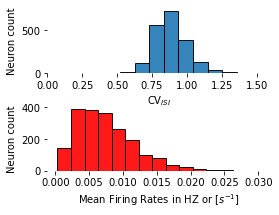

In [32]:
fig, axs = plt.subplots(2, 1, figsize=(4, 3))
sp = [i+N2 for i in M1G1.i] #commencer avec un 1er spike #par neuron
times = M1G1.t/ms
nNeurons = max(sp) + 1
nSpikes = len(sp)

spiketimes = {}
for n in np.arange(nNeurons):
    ts = list(times[(np.where(sp == n))])
    #ts = [tau_range/ms for tau_range/ms in ts if tau_range/ms > 500 * ms]
    spiketimes[n] = ts
isi_stds = []
isi_cvs = []
for n in range(nNeurons):
    isi_std = np.std(np.diff(spiketimes[n]))
    isi_cv = np.std(np.diff(spiketimes[n])) / np.mean(np.diff(spiketimes[n]))
        #plt.scatter(n, np.std(np.diff(spiketimes[n])))
    isi_stds.append(isi_std)  
    isi_cvs.append(isi_cv)
        
meanFiringRates = []
for n in range(nNeurons):
    meanFiringRates.append(1/np.mean(np.diff(spiketimes[n])))
        
    

axs[0].hist(isi_cvs, bins=15, alpha=0.9, edgecolor='black');
axs[1].hist(meanFiringRates, bins=15, alpha=0.9, edgecolor='black',color="red");
    
for k in range(1):
    leg = axs[k].legend(loc=1)
    leg.get_frame().set_facecolor('none')
    leg.get_frame().set_linewidth(0.0)
   
for k in range(2):
    axs[k].spines['right'].set_visible(False)
    axs[k].spines['top'].set_visible(False)
    axs[k].spines['bottom'].set_visible(False)
    axs[k].spines['left'].set_visible(False)
#axs[0].set_xticks([0, 0.5, 1.0])
#axs[0].set_yticks([0, 10, 20])

axs[0].set_xlim(0, 1.6)
axs[0].set_xlabel("CV$_{ISI}$")
axs[1].set_xlabel("Mean Firing Rates in HZ or [$s^{-1}$]")

axs[0].set_ylabel("Neuron count")
axs[1].set_ylabel("Neuron count")

plt.subplots_adjust(hspace=0.5)

0.6726054740715591 0.1437914891657445 7.180445346053321 0.3852415765721023


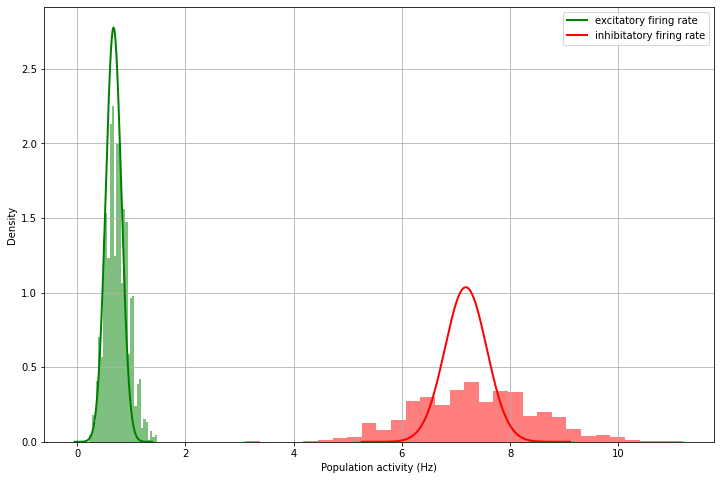

In [12]:
import scipy.stats

def gaussian(x,mean,std):
    return 1/(np.sqrt(2*math.pi*std**2))*math.exp(-(x-mean)**2/(2*std**2))

plt.figure(figsize=(12,8))

'''Remove transient'''

ST_popRateG1=popRateG1[int(len(popRateG1)/5)::] 
ST_popRateG2=popRateG2[int(len(popRateG2)/5)::]

plt.hist(ST_popRateG1,density=True, color='r', bins=30, alpha=0.5)
plt.hist(ST_popRateG2,density=True, color='g', bins=30, alpha=0.5)


mean_RS=final_state[0]
std_RS=np.sqrt(final_state[2])

mean_FS=final_state[1]
std_FS=np.sqrt(final_state[5])

print(mean_RS,std_RS,mean_FS,std_FS)

x_min_RS=mean_RS-5*std_RS #x_min_RS=mean_RS-5*std_RS
x_max_RS=mean_RS+5*std_RS

x_min_FS=mean_FS-5*std_FS
x_max_FS=mean_FS+5*std_FS

x_RS = np.linspace(x_min_RS, x_max_RS, 1000)
x_FS = np.linspace(x_min_FS, x_max_FS, 1000)

Distrib_RS=[]
Distrib_FS=[]


for i in range(len(x_RS)):
    Distrib_RS.append(gaussian(x_RS[i],mean_RS,std_RS))
    Distrib_FS.append(gaussian(x_FS[i],mean_FS,std_FS))


plt.plot(x_RS,Distrib_RS,color='g',lw=2,label='excitatory firing rate')
plt.plot(x_FS,Distrib_FS,color='r',lw=2, label='inhibitatory firing rate')
                             
plt.xlabel("Population activity (Hz)")
plt.grid(True)
plt.ylabel("Density")
plt.legend()
plt.show()

### Draw distribution

In [74]:
print(np.array(LwG2).mean())

1.1308564587070542e-08


In [46]:
x_transp=np.transpose(x_trace_RS)
TF_transp=np.transpose(TF_trace_RS)
ve=x_transp[0]#[1000:] # remove first 10000 elements
vi=x_transp[1]#[1000:]
cee=np.sqrt(x_transp[2])#[1000:]
cei=x_transp[3]#[1000:]
cie=x_transp[4]#[1000:]
cii=np.sqrt(x_transp[5])#[1000:]
w=x_transp[6]
Lt2G2=array(M3G2.t/ms)
mean_LwG2=np.mean(LwG2,axis=0)
print(len(mean_LwG2))
cut_mean_LwG2=mean_LwG2[90000:]

#cv_i=cee/ve
#cv_e=cii/vi
#print(cee[:1000],cii[:1000])

100000


In [58]:
print(mean_LwG2)

[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 2.54616560e-09
 2.54591098e-09 2.54565639e-09]


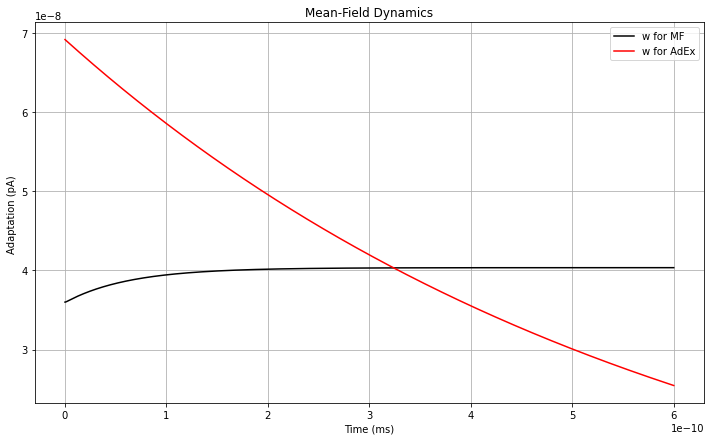

In [71]:
plt.figure(figsize=(12, 7))
#plt.plot(t_trace, ve, color="green", label="excitatory firing rate")
#plt.plot(t_trace, vi, color="red", label="inhibitory firing rate")
#plt.plot(TimBinned/1000,  popRateG2, color="green",ls="--", label="excitatory firing rate")
#plt.plot(TimBinned/1000, popRateG1, color="red",ls="--", label="inhibitory firing rate")
#plt.plot(t_trace, cee, color="blue", label="excitory cee")
#plt.plot(t_trace, cii, color="purple", label="inhibitory cii")
#plt.plot(t_trace, cei, color="yellow", label="cei")
#plt.plot(t_trace, cie, color="orange", label="cie")
b=np.linspace(0,60,10000)*10e-12
plt.plot(b,w*1e3,color="black",label="w for MF")
for a in range(Nrecord):
    #plt.plot(Ltime, LVG1[a],'r',label='RS cells') 
    plt.plot(b,mean_LwG2[90000:100000]*10,'r',label='w for AdEx')
#plt.plot(t_trace2, ve2, color="green", ls="--")
#plt.plot(t_trace2, vi2, color="red", ls="--")
#plt.plot(t_trace,test_input, color="black", linestyle=":", label="forcing")



plt.xlabel("Time (ms)")
plt.grid(True)
plt.ylabel("Adaptation (pA) ")
plt.legend()
plt.title("Mean-Field Dynamics")
#plt.ylim(-20,20)
#plt.xlim(0,0.1)
plt.show()

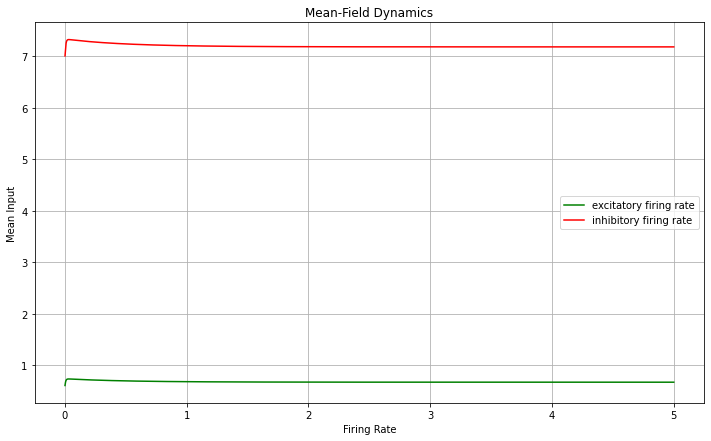

In [68]:
plt.figure(figsize=(12, 7))
plt.plot(t_trace, ve, color="green", label="excitatory firing rate")
plt.plot(t_trace, vi, color="red", label="inhibitory firing rate")
#plt.plot(TimBinned/1000,  popRateG2, color="green",ls="--", label="excitatory firing rate")
#plt.plot(TimBinned/1000, popRateG1, color="red",ls="--", label="inhibitory firing rate")
#plt.plot(t_trace, cee, color="blue", label="excitory cee")
#plt.plot(t_trace, cii, color="purple", label="inhibitory cii")
#plt.plot(t_trace, cei, color="yellow", label="cei")
#plt.plot(t_trace, cie, color="orange", label="cie")
#plt.plot(t_trace,w2*1e5,color="black",label="w")
#plt.plot(t_trace2, ve2, color="green", ls="--")
#plt.plot(t_trace2, vi2, color="red", ls="--")
#plt.plot(t_trace,test_input, color="black", linestyle=":", label="forcing")



plt.xlabel("Firing Rate")
plt.grid(True)
plt.ylabel("Mean Input")
plt.legend()
plt.title("Mean-Field Dynamics")
#plt.ylim(-20,20)
#plt.xlim(0,0.1)
plt.show()

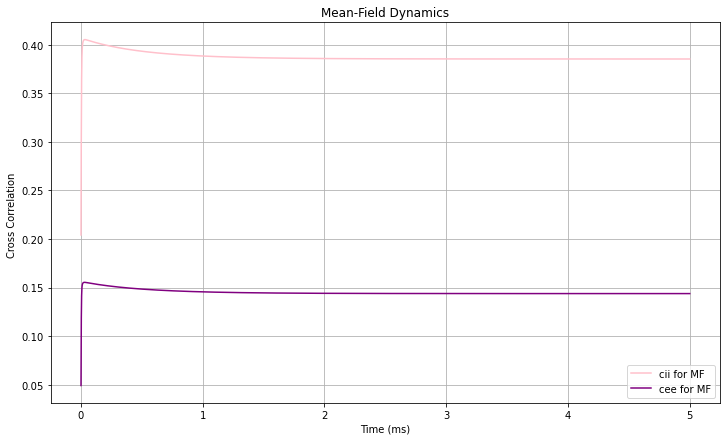

In [33]:
plt.figure(figsize=(12, 7))
#plt.plot(t_trace, ve, color="green", label="excitory firing rate")
#plt.plot(t_trace, vi, color="red", label="inhibitory firing rate")
#plt.plot(t_trace, cee, color="blue", label="excitory cee")
plt.plot(t_trace, cii, color="pink", label="cii for MF")
plt.plot(t_trace, cee, color="purple", label="cee for MF")
#plt.plot([-t_trace,t_trace], cie*1e-4, color="orange", label="cie")
#plt.plot(t_trace,w2*1e5,color="black",label="w")
#plt.plot(t_trace2, ve2, color="green", ls="--")
#plt.plot(t_trace2, vi2, color="red", ls="--")
#plt.plot(t_trace,test_input, color="black", linestyle=":", label="forcing")



plt.xlabel("Time (ms)")
plt.grid(True)
plt.ylabel("Cross Correlation ")
plt.legend()
plt.title("Mean-Field Dynamics")
#plt.ylim(0,6000)
#plt.xlim(0,0.1)
plt.show()

### Now... MAKE SOME NOISE !!!

##### ...(define noise functions and parameters)

In [10]:
def Ornstein_U_list(xi_0,dt,tot_time,tau):
    
    for i in np.arange(0,tot_time,dt):
        xi_0+=-dt*xi_0/tau+np.sqrt(dt)*np.random.randn()
        
###   To integrate in the MF, it needs to be written as a function

def OU_func_list(t,O_U_list):
    return O_U_list[t]

def Ornstein_func(xi_0,dt,tau):
    
    return xi_0-dt*xi_0/tau+np.sqrt(dt)*np.random.randn()
    

In [12]:
np.random.seed(10)
import datetime ### To keep track of time, might be useful, little bit like a watch
x0=final_state.copy()
print(x0)
time=0
t_trace2=[]
#T=0.005
#x_trace_aWITHTAU=[]
x_trace_RS_with_noise=[]
TF_trace_RS_with_noise=[]

drive=[]
params['tstep']=1e-4
params['T']=0.005


xi_exc=0 ## O_U process
xi_inh=0


print(x0)
time=0
    
for i in np.arange(0,5,params['tstep']):
    TF_inst= Euler_method_General(x0,params,time,MeanField_dN_dp_Hybrid_noise)
    
    xi_exc=Ornstein_func(xi_exc,params['tstep'],5e-4)
    xi_inh=Ornstein_func(xi_inh,params['tstep'],5e-4)

    params['ext_inp'][0]=2.0+10.5*xi_exc    
    params['ext_inp'][1]=2.0+10.5*xi_inh
    
    if (i%0.5==0):
        print('i = ', i, '\n')
        print('time : ', datetime.datetime.now(), ' \n \n')
    time+=params['tstep']
    t_trace2.append(time)
    
    x_trace_RS_with_noise.append(x0.copy())
    TF_trace_RS_with_noise.append(TF_inst.copy())
    drive.append(params['ext_inp'])
    

[3.55974463e+00 1.36879000e+01 6.81682739e-01 1.32181306e+00
 1.32181306e+00 2.91536730e+00 3.54463365e-12]
[3.55974463e+00 1.36879000e+01 6.81682739e-01 1.32181306e+00
 1.32181306e+00 2.91536730e+00 3.54463365e-12]


KeyError: 'noise'

In [74]:
final_state2=x_trace_RS_with_noise[-1]
print(final_state2)

[6.28448512e-01 5.75199506e+00 1.84910657e-01 2.45127628e-01
 2.45127628e-01 5.44513046e-01 3.48137111e-11]


### Now plot the time traces !

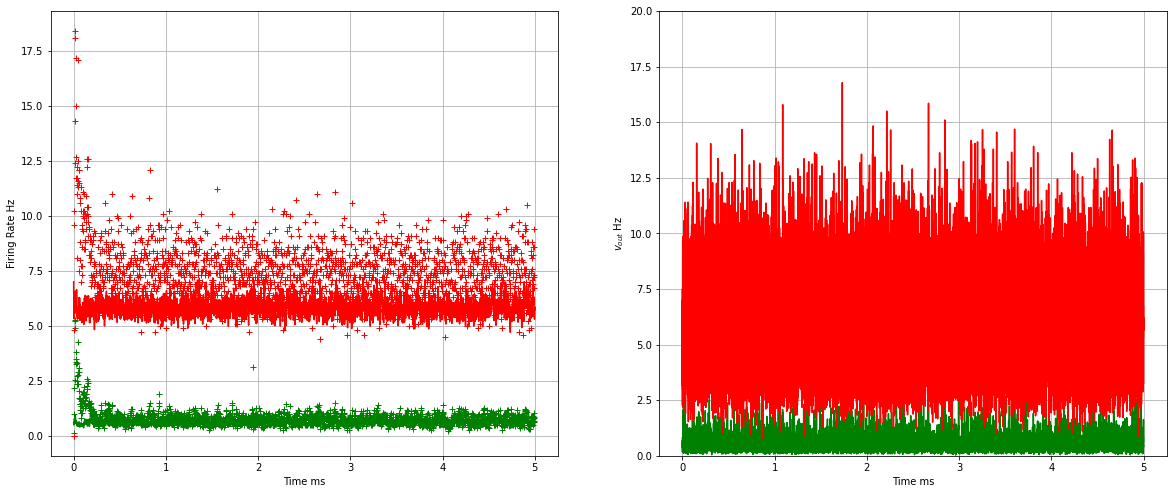

In [75]:
x_transp=np.transpose(x_trace_RS_with_noise)
TF_transp=np.transpose(TF_trace_RS_with_noise)

# RK terms 
ve=x_transp[0]#[1000:] # remove first 10000 elements
vi=x_transp[1]#[999:]
cee=np.sqrt(x_transp[2])#[1000:] #cross correlation
cei=x_transp[3]#[1000:]
cie=x_transp[4]#[1000:]
cii=np.sqrt(x_transp[5])#[1000:]
w=x_transp[6]

fig2=plt.figure(figsize=(20,18))
ax21=fig2.add_subplot(221)
ax22=fig2.add_subplot(222)

##### Load and plot the network activity of your choice ! #####

#BIN, TimBinned, popRateI,popRateIosc,popRateE,LfrG1,LfrG2,LfrG3=\
#np.load('../../PopRate_of_your_choice.npy',allow_pickle=True)
#ax21.plot(t_trace1,  ve1, color="green", label="excitory firing rate")
#ax21.plot(t_trace1, vi1, color="red", label="inhibitory firing rate")
#ax21.plot(TimBinned/1000,  popRateG1, color="blue", label="excitatory firing rate")
#ax21.plot(TimBinned/1000, popRateG2, color="yellow", label="inhibitory firing rate")
#ax21.plot(TimBinned/1000, popRateIosc, color="purple",ls="--", label="inhibitory firing rate")

ax21.plot(t_trace2,  ve, color="green", label="exc FR mean-field")
ax21.plot(t_trace2, vi, color="red", label="inh FR mean-field")
ax21.plot(TimBinned/2000,  popRateG2, 'g+', label="exc FR AdEx")
ax21.plot(TimBinned/2000, popRateG1, 'r+', label="inh FR AdEx")
#ax21.plot(t_trace, vib, color="orange",ls="--", label="inhibitory firing rate")

#ax21.plot(t_trace, cee, color="blue", label="inhibitory firing rate")
#ax21.plot(t_trace, ciaia, color="purple", label="inhibitory firing rate")
#ax21.plot(t_trace, cibib, color="yellow", label="inhibitory firing rate")

#ax21.set_ylim(0.1,10)
ax21.set_ylabel('Firing Rate Hz')
ax21.set_xlabel('Time ms')
ax21.grid(True)

###### Plot the instantaneous transfer functions #######

ax22.plot(t_trace2,  TF_transp[0], color="green", label="excitory TF")
ax22.plot(t_trace2, TF_transp[1], color="red", label="inhibitory TF")
#ax22.plot(t_trace, TF_transp_BNet_8p7[1], color="red",ls="--", label="inhibitory TF")
#ax22.set_xlim(0.9,1)
ax22.set_ylim(0,20)
ax22.set_ylabel('$v_{out}$ Hz')
ax22.set_xlabel('Time ms')
ax22.grid(True)

In [178]:
LwG2[a].limit()

AttributeError: 'numpy.ndarray' object has no attribute 'limit'

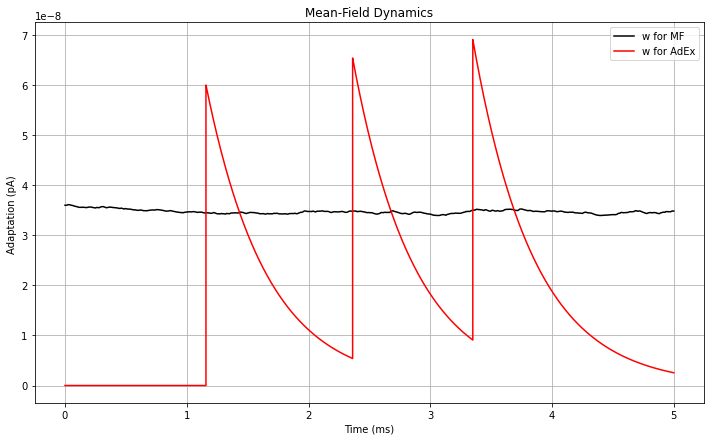

In [78]:
plt.figure(figsize=(12, 7))
#plt.plot(t_trace, ve, color="green", label="excitory firing rate")
#plt.plot(t_trace, vi, color="red", label="inhibitory firing rate")
#plt.plot(t_trace, cee, color="blue", label="excitory cee")
#plt.plot(t_trace, cii, color="purple", label="inhibitory cii")
#plt.plot(t_trace, cei, color="yellow", label="cei")
#plt.plot(t_trace, cie, color="orange", label="cie")
plt.plot(t_trace2,w*1e3,color="black",label="w for MF")
for a in range(Nrecord):
    #plt.plot(Ltime, LVG1[a],'r',label='RS cells') 
    plt.plot(Lt2G2/2000, mean_LwG2,'r',label='w for AdEx')
    #plt.plot(Ltime, LVG2[a],'g',label='FS cells')
    #plt.plot(Ltime, LwG2[a],'g',label='FS cells')
#plt.plot(t_trace2, ve2, color="green", ls="--")
#plt.plot(t_trace2, vi2, color="red", ls="--")
#plt.plot(t_trace,test_input, color="black", linestyle=":", label="forcing")



plt.xlabel("Time (ms)")
plt.grid(True)
plt.ylabel("Adaptation (pA) ")
plt.legend()
plt.title("Mean-Field Dynamics")
#plt.ylim(0,5e-8)
#plt.xlim(3,10)
plt.show()

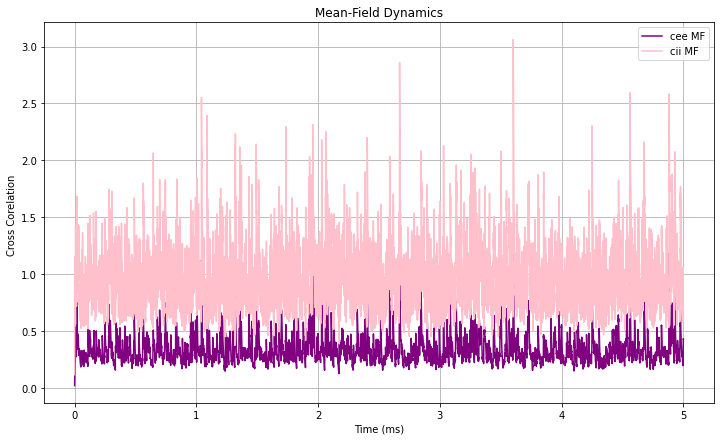

In [79]:
plt.figure(figsize=(12, 7))
#plt.plot(t_trace, ve, color="green", label="excitory firing rate")
#plt.plot(t_trace, vi, color="red", label="inhibitory firing rate")
#plt.plot(t_trace2, cee, color="blue", label="excitory cee")
#plt.plot(t_trace2, cii, color="purple", label="inhibitory cii")
plt.plot(t_trace2, cee, color="purple", label="cee MF")
plt.plot(t_trace2, cii, color="pink", label="cii MF")
#plt.plot(t_trace2, cie, color="orange", label="cie")
#plt.plot(t_trace2,w*1e3,color="black",label="w")
#for a in range(Nrecord):
    #plt.plot(Ltime, LVG1[a],'r',label='RS cells') 
    #plt.plot(Ltime/1000, LwG2[a],'r',label='RS cells')
    #plt.plot(Ltime, LVG2[a],'g',label='FS cells')
    #plt.plot(Ltime, LwG2[a],'g',label='FS cells')
#plt.plot(t_trace2, ve2, color="green", ls="--")
#plt.plot(t_trace2, vi2, color="red", ls="--")
#plt.plot(t_trace,test_input, color="black", linestyle=":", label="forcing")



plt.xlabel("Time (ms)")
plt.grid(True)
plt.ylabel("Cross Corelation ")
plt.legend()
plt.title("Mean-Field Dynamics")
#plt.ylim(-0.01,2)
#plt.xlim(0,0.1)
plt.show()

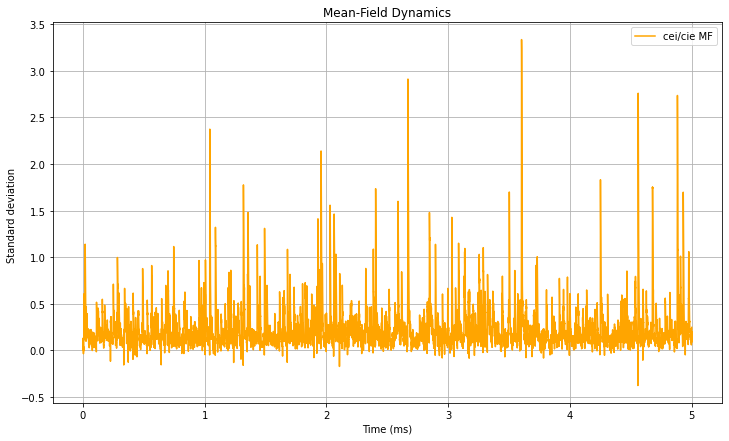

In [80]:
plt.figure(figsize=(12, 7))
#plt.plot(t_trace, ve, color="green", label="excitory firing rate")
#plt.plot(t_trace, vi, color="red", label="inhibitory firing rate")
plt.plot(t_trace2, cei, color="orange", label="cei/cie MF")
#plt.plot(t_trace2, cii, color="orange", label="inhibitory cii")
#plt.plot(t_trace2, cei, color="purple", label="cei/cie")
#plt.plot(t_trace2, cie, color="orange", label="cie")
#plt.plot(t_trace2,w*1e3,color="black",label="w")
#for a in range(Nrecord):
    #plt.plot(Ltime, LVG1[a],'r',label='RS cells') 
    #plt.plot(Ltime/1000, LwG2[a],'r',label='RS cells')
    #plt.plot(Ltime, LVG2[a],'g',label='FS cells')
    #plt.plot(Ltime, LwG2[a],'g',label='FS cells')
#plt.plot(t_trace2, ve2, color="green", ls="--")
#plt.plot(t_trace2, vi2, color="red", ls="--")
#plt.plot(t_trace,test_input, color="black", linestyle=":", label="forcing")



plt.xlabel("Time (ms)")
plt.grid(True)
plt.ylabel("Standard deviation ")
plt.legend()
plt.title("Mean-Field Dynamics")
#plt.ylim(-0.01,2)
#plt.xlim(0,0.1)
plt.show()